In [2]:
#%%
import pandas as pd
import numpy as np
import dask.dataframe as dd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics, svm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('c:/Users/joe/desktop/train_2016_v2.csv',parse_dates=['transactiondate'])

# load the properties data
prp = pd.read_csv('c:/Users/joe/desktop/properties_2016.csv')

merged = pd.merge(train,prp,on='parcelid',how='left')

In [4]:
# Linear Variable Combinations
merged['property_age'] = 2018 - merged['yearbuilt']
merged['total_rooms'] = merged['calculatedbathnbr'] + merged['bedroomcnt']
merged['garage_yn'] = np.where((merged['garagecarcnt'] > 0) | (merged['garagetotalsqft'] > 0),1,0)
merged['prop_to_land'] = merged['structuretaxvaluedollarcnt']/merged['landtaxvaluedollarcnt']
merged['length_tax_delinq'] = 2018 - merged['taxdelinquencyyear']
merged['coords'] = merged['latitude']/(10^6) + merged['longitude']/(10^6)
zip_count = merged['regionidzip'].value_counts().to_dict()
merged['zip_counts'] = merged['regionidzip'].map(zip_count)
city_count = merged['regionidcity'].value_counts().to_dict()
merged['city_counts'] = merged['regionidcity'].map(city_count)
county_count = merged['regionidcounty'].value_counts().to_dict()
merged['county_counts'] = merged['regionidcounty'].map(county_count)
merged['ac_yn'] = (merged['airconditioningtypeid']!=5)*1
merged['heat_yn'] = (merged['heatingorsystemtypeid']!=13)*1
merged['property_type'] = merged.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed",
      246 : "Mixed", 247 : "Mixed", 248 : "Mixed",
      260 : "Home", 261 : "Home", 262 : "Home",
      263 : "Home", 264 : "Home", 265 : "Home",
      266 : "Home", 267 : "Home", 268 : "Home",
      269 : "Not Built", 270 : "Home", 271 : "Home",
      273 : "Home", 274 : "Other", 275 : "Home",
      276 : "Home", 279 : "Home", 290 : "Not Built",
      291 : "Not Built" }) 
# structuretaxvaluedollarcnt by city
group = merged.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merged['stvdc_avg_bycity'] = merged['regionidcity'].map(group)
merged['stvdc_avg_dev'] = abs((merged['structuretaxvaluedollarcnt'] - merged['stvdc_avg_bycity']))/merged['stvdc_avg_bycity']

In [5]:
high = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),99)
low = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),1)
mor = merged[(np.log(merged['taxvaluedollarcnt']) > low) & (np.log(merged['taxvaluedollarcnt']) < high)]

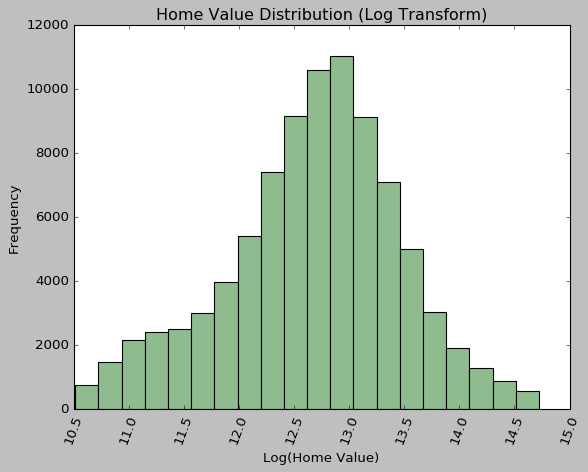

In [5]:
plt.style.use('classic')
fig,ax = plt.subplots()
high = np.percentile(merged['taxvaluedollarcnt'].dropna(),99)
low = np.percentile(merged['taxvaluedollarcnt'].dropna(),1)
mor = merged[(merged['taxvaluedollarcnt'] > low) & (merged['taxvaluedollarcnt'] < high)]
plt.hist(np.log(mor['taxvaluedollarcnt']),bins=20, color='darkseagreen')
plt.title('Home Value Distribution (Log Transform)')
plt.ylabel('Frequency')
plt.xlabel('Log(Home Value)')
plt.xticks(rotation = 70)
plt.show()

In [9]:
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = (mor['taxvaluedollarcnt'])
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False]}
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)
grid.fit(xtrain,ytrain)
print("Random Forest MAE:",np.mean(np.abs(grid.predict(xtest)-ytest)))

Random Forest MAE: 4098.754992293216


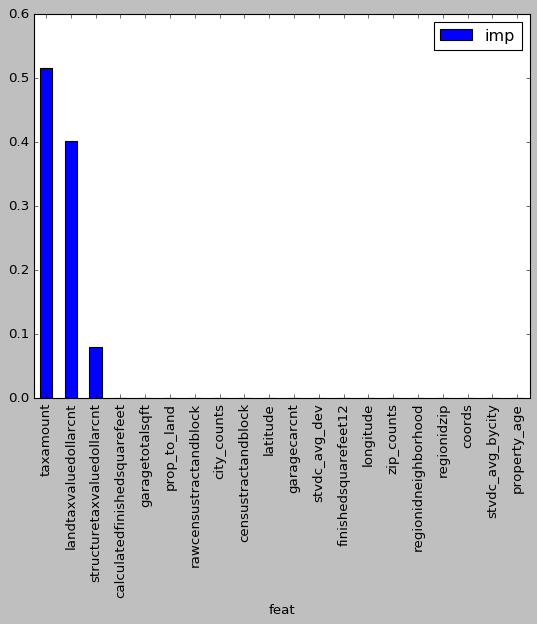

In [10]:
# Feature Importance
feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':xtrain.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.head(20).plot.bar()

In [7]:
# Random Forest Without Multicollinearity
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = mor['taxvaluedollarcnt']
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False]}
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)
grid.fit(xtrain,ytrain)
print("Random Forest MAE:",np.mean(np.abs(grid.predict(xtest)-ytest)))

Random Forest MAE: 52256.74709649679


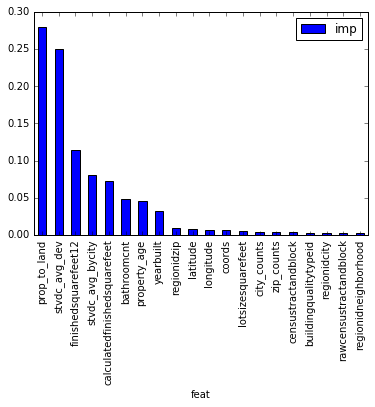

In [14]:
# Feature Importance
feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':xtrain.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.head(20).plot.bar()

In [8]:
# Linear Regression
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(xtrain, ytrain)
pred = regr.predict(xtest)
print("Linear Regression MAE:",np.mean(np.abs(regr.predict(xtest)-ytest)))

0.466684237280796
Linear Regression MAE: 175362.5802386089


In [9]:
# Lasso
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1e-6,normalize=True,max_iter=10000)
clf.fit(xtrain,ytrain)
lpred = clf.predict(xtest)
print("LASSO Regression MAE:",np.mean(np.abs(clf.predict(xtest)-ytest)))

LASSO Regression MAE: 175354.80296260628


In [10]:
# Elastic Net
#from sklearn import linear_model
clf = linear_model.ElasticNet(alpha=1e-6,normalize=True)
clf.fit(xtrain,ytrain)
lpred = clf.predict(xtest)
print("Elastic Net MAE:",np.mean(np.abs(regr.predict(xtest)-ytest)))

Elastic Net MAE: 175362.5802386089


In [11]:
# K Nearest Neighbor Regressor
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=100)
reg.fit(xtrain,ytrain)
kpred = reg.predict(xtest)
print("K Nearest Neighbor MAE:",np.mean(np.abs(reg.predict(xtest)-ytest)))

K Nearest Neighbor MAE: 194072.18395478444


In [12]:
# Neural Network Model
from sklearn.neural_network import MLPRegressor
# Normalize Data
train_y=(ytrain-ytrain.min())/(ytrain.max()-ytrain.min())
train_x=(xtrain-xtrain.min())/(xtrain.max()-xtrain.min())
test_x=(xtest-xtest.min())/(xtest.max()-xtest.min())
test_y=(ytest-ytest.min())/(ytest.max()-ytest.min())
train_y = train_y.fillna(0)
train_x = train_x.fillna(0)
test_y = test_y.fillna(0)
test_x = test_x.fillna(0)
nnreg = MLPRegressor(hidden_layer_sizes=(100,),activation='logistic',solver='lbfgs',max_iter=10000)
nnreg.fit(train_x,train_y)
nnpred = nnreg.predict(test_x)
print("Neural Network MSE:",np.mean(np.abs(nnreg.predict(xtest)-ytest)))

Neural Network MSE: 427076.4927815374
